<a href="https://colab.research.google.com/github/lingchm/datascience/blob/master/exercises/socially_distanced_robots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Compression

*clustering*, *kmeans*, *kmedoids*

**Problem**

Given an image in the form of an array $X$, compress the image to different resolutions.

**Method**

We will perform image compression using clustering. Clustering algorithms allow us to identify pixels of similar colors and group them together, picking a representative color of each group, and hence reducing the overall picture size. Clustering algorithm can be viewed as an optimization problem where the objective function is to minimize the total distance between each data point and their assigned clusters.

We will implement and compare two clustering algorithms in the setting of image compression: K-means and K-medoids.


## Algorithm Overview

**K-medoids**
The K-medoids algorithm implementation is summarized as:
1. **Initialization**: randomly picked k pixels from the image as initial centroids
2. **Cluster assignment**: the distance between each data point with each centroid is computed. The data point is then assigned to its closest centroid 
3. **Cluster adjustment**: after reevaluating distances between data points and centroids, the new set of k data points is chosen to be the representatives in the way that the distortion function is minimized. Refer to "Choosing centroids" section for implementation details 
4. Iterate step 2 and 3 until stopping criteria is met 

**K-Means**
In contrast, the K-means algorithm implementation is summarized as:
1. **Initialization**: randomly generated k pixels (each with three RGB values between 0 and 255) as initial centroids
2. **Cluster assignment**: the distance between each data point with each centroid is computed. The data point is then assigned to its closest centroid 
3. **Cluster adjustment**: for each cluster, the average of the data points assigned to that cluster is calculated and it becomes the new cluster representative. 
4. Iterate step 2 and 3 until stopping criteria is met 

## Implementation details

The function `compressKmedoids(pixels, k)` runs the K-medoid algorithm and `compressKmeans(pixels, k)` runs the K-means algorithm. Both take in as input:
* `pixels`: the input image representation. Each row contains one data point (pixel). For image dataset. Each row contains 3 columns, each column corresponding to Red, Green, and Blue component. Each component has an integer value between 0 and 255.
* `k`: the number of desired clusters
and output:
* `assignments`: cluster assignment matrix of each data point in pixels of size size(pixels, 1) elements.
* `centroid`: location of k centroids

The function `createImage(compressed, title, footnote)` and `createPlot(x_values, y_values)` are utility functions used to support the main functions.


**Centroid Initialization**

There are two options for centroid initialization:
* Random: the default setting is random, which is described in the previous two sections. User can choose this setting as: `initType = "random"`

* Manual: the test the robustness of the two algorithms, the manual setting intentionally generates initial centroids as $[0,0,0],[1,1,1], \dots [k,k,k]$. These centroids are intentionally made to be poor as they are all very similar black shaped colors. User can choose this setting as: `initType = "manual"`


**Distance Measures**

This implementation was done using two different distance meausres $D(x, y)$:
* Squared Euclidean or squared norm 2 distance: $D(x,y) = ||x-y||^2$. This distance is used as the primary implementation for both K-medoid and K-means. User can choose this setting under "global parameters" as: `distType = "l2"`

* Manhanttan or norm 1 distance: $D(x,y) = |x-y|$. This distance is used to compare to the performance og squared l2. User can choose this setting under "global parameters" as: `distType = "l1"`

**Choosing Centroids**

* For K-means algorithm, it is clear that for each iteration, the average of the data points of each cluster becomes the new centroid of the cluster.

* For K-medoids under squared l2 distance, it can be shown that the medoid correspond to the data point closest to the cluster average. Therefore, we first obtained the average of all data points in a cluster, then computed the Euclidean distance between each data point and the average, and finally selected the data point that is closest to the average as the new representative. 

* For k-medoids under Manhanttan distance, in each iteration for each cluster, the distance between every data point is calculated as a distance matrix. Then, the data point whose sum of distances to every data point in that cluster is the smallest is chosen as the new representative. Since this computation is expensive, downsampling was applied. A downsample of 10% would randomly pick 10 data points of the cluster and pick a centroid from there. User can change downsampling percentages under "global parameters" as: `percdownsample = 0.1`

**Stopping criteria**

Two stopping criterias were used in conjunction:
* If the decrease of the objective function value is greater than a very small number $\epsilon$. User can change this setting under "global parameters" as: `epsilon = 1e-6`
    
* If the number of iterations reach a maximum as set by the user. User can change this setting under "global parameters": `maxiter = 200`

**K Reduction**

When the number of clusters $k$ is large, it is possible that some clusters have zero data points assigned to them. These cases produce lead to dividions by zero when calculating the cluster average. To avoid this error, the implementation will reassign the centroid of that cluster using the selected centroid initialization criteria. User can reference the compressed image outputs to deteremine whether K reduction was applied.



In [1]:
import scipy.io as sio
import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, find
import imageio 
import copy
import time
from random import sample
from itertools import permutations 

In [11]:
# global parameters:
maxiter = 200           # maximum iterations
epsilon = 1e-6
np.random.seed(0)       # set fixed seed to get same results everytime

In [7]:
def compressKmedoids(pixels, k, distType='l2', initType='random', percdownsample=0.1):
    m = pixels.shape[1]     # number of data points to work with;
    iter = 0
    tic = time.time()
    decreasedk = ""
    y_values, x_values = [], []
    pixels = pixels.astype(np.int64)

    # initialize k centroids by randomly picking k data points from existing pixels
    centroids = pixels[:, np.random.randint(m, size=(1, k))[0]]    
    # purposefully use a bad initialization           
    if initType == "manual":
        for i in range(k):
            centroids[:, i] = i  
    centroids_old = copy.deepcopy(centroids) + 100 

    while np.linalg.norm(centroids - centroids_old, ord='fro') > epsilon and iter < maxiter:
        
        # assign data points to centroids based on closest distance
        dist = np.empty([m, k])
        if distType == "l1": 
            for j in range(k):
                diff = pixels.T - centroids[:, j].T
                absdiff = np.absolute(diff)
                dist[:, j] = np.sum(absdiff, axis=1)
        else:
            centroidsnorm2 = np.sum(np.power(centroids, 2), axis=0)
            pixelnorm2 = np.sum(np.power(pixels, 2), axis=0)
            dist = - 2 * np.dot(pixels.T, centroids) + np.matlib.repmat(centroidsnorm2, m, 1) + np.matlib.repmat(pixelnorm2, k, 1).T
            
        labels = np.argmin(dist, axis=1)
        P = csc_matrix((np.ones(m), (np.arange(0, m, 1), labels)), shape=(m, k))

        # calculate objective function
        J = 0
        for j in range(0, k):
            idx = find(P[:, j])[0]
            J = J + np.sum(dist[idx, j], axis=0)
        y_values.append(J)
        x_values.append(iter)
        #print("--iteration %d \n" % iter)
        #print(J)

        count = P.sum(axis=0)
        # if some clusters have not been assigned any data point, restart with a smaller k
        if np.count_nonzero(count) != count.shape[1]:
            k = k - 1
            centroids = pixels[:, np.random.randint(m, size=(1, k))[0]]                        
            centroids_old = copy.deepcopy(centroids) + 100 
            decreasedk = "Empty clusters ocurred. Used deducted k"
        else:
            # reassign centroids computing the distance between every data point in a cluster
            centroids_old = copy.deepcopy(centroids)
            if distType == "l1":
                # for each cluster find new representative
                for j in range(k):
                    idx_all = find(P[:, j])[0]
                    idx = sample(idx_all.tolist(), int(percdownsample * len(idx_all)))
                    cluster = pixels[:, idx].T
                    dist = np.empty([len(idx), len(idx)])
                    # calculate distance between each data point and each other
                    for i in range(len(idx)):
                        diff = cluster - np.matlib.repmat(cluster[i, :], len(idx), 1) 
                        absdiff = np.absolute(diff)
                        dist[:, i] = np.sum(absdiff, axis=1)
                    totdist = np.sum(dist, axis=1)
                    # representative will be the one with smallest total distance
                    labels = np.argmin(totdist, axis=0)
                    centroids[:, j] = cluster[labels, :]
            else: # Euclidean distance
                avg = np.array((P.T.dot(pixels.T)).T / count)       # avg of each cluster 
                avgnorm2 = np.sum(np.power(avg, 2), axis=0)         # norm of each avg vector
                dist = - 2 * np.dot(pixels.T, avg) + np.matlib.repmat(avgnorm2, m, 1) + np.matlib.repmat(pixelnorm2, k, 1).T
                labels = np.argmin(dist, axis=0)                 
                centroids = pixels[:, labels]
        iter += 1

    # create an array of cluster assignments
    assignments = numpy.empty([m, 1], dtype = int)
    for j in range(0, k):
        idx = find(P[:, j])[0] 
        assignments[idx, 0] = j + 1
        pixels[:, idx] = np.matlib.repmat(centroids[:, j], idx.shape[0], 1).T
    
    # visualize image
    compressed = np.reshape(pixels.T, (height, width, colors), 'C')
    toc = time.time()
    duration = float(toc - tic)
    if iter < maxiter:
        footnote = " Convergence at iter = " + str(iter) + ". Runtime is %f seconds \n" % duration + ". " + decreasedk
    else:
        footnote = " No convergence within " + str(maxiter) + " iterations. Runtime is %f seconds \n" % duration + ". " + decreasedk
    title = "Compressed image using K-medoids with k = " + str(k) 
    createImage(compressed, title, footnote)

    # graph objective function 
    createPlot(x_values, y_values)

    # output
    return assignments, centroids

In [8]:
def compressKmeans(pixels, k, distType='l2', initType='random'):
    m = pixels.shape[1]     # number of data points to work with;
    iter = 0
    tic = time.time()
    decreasedk = ""
    y_values, x_values = [], []
    pixels = pixels.astype(np.uint64)

    # randomly initialize k centroids
    centroids = 6 * np.random.rand(colors, k) 
    # purposefully use a bad initialization           
    if initType == "manual":
        for i in range(k):
            centroids[:, i] = i                     
    centroids_old = copy.deepcopy(centroids) + 100 
    
    while np.linalg.norm(centroids - centroids_old, ord='fro') > epsilon and iter < maxiter:

        # assign data points to centroids based on closest Euclidean distance
        centroidsnorm2 = np.sum(np.power(centroids, 2), axis=0)
        pixelnorm2 = np.sum(np.power(pixels, 2), axis=0)
        dist = - 2 * np.dot(pixels.T, centroids) + np.matlib.repmat(centroidsnorm2, m, 1) + np.matlib.repmat(pixelnorm2, k, 1).T
        labels = np.argmin(dist, axis=1)
        P = csc_matrix((np.ones(m), (np.arange(0, m, 1), labels)), shape=(m, k))
        
        # calculate objective function
        J = 0
        for j in range(0, k):
            idx = find(P[:, j])[0]
            J = J + np.sum(dist[idx, j], axis=0)
        y_values.append(J)
        x_values.append(iter)
        #print("--iteration %d \n" % iter)
        #print(J)

        count = P.sum(axis=0)
        # if some clusters have not been assigned any data point, restart with a smaller k
        if np.count_nonzero(count) != count.shape[1]:
            k = k - 1
            centroids = 6 * np.random.rand(colors, k)                    
            centroids_old = copy.deepcopy(centroids) + 100 
            decreasedk = "Empty clusters ocurred. Used deducted k"
        else:
            # reassign centroids as the average of the data points in the cluster
            centroids_old = copy.deepcopy(centroids)
            centroids = np.array((P.T.dot(pixels.T)).T / count)
        iter += 1

    # create an array of cluster assignments
    assignments = numpy.empty([m, 1], dtype = int)
    for j in range(0, k):
        idx = find(P[:, j])[0] 
        assignments[idx, 0] = j + 1
        pixels[:, idx] = np.matlib.repmat(centroids[:, j], idx.shape[0], 1).T
    
    # visualize image
    compressed = np.reshape(pixels.T, (height, width, colors), 'C')
    toc = time.time()
    duration = float(toc - tic)
    if iter < maxiter:
        footnote = " Convergence at iter = " + str(iter) + ". Runtime is %f seconds \n" % duration + ". " + decreasedk
    else:
        footnote = " No convergence within " + str(maxiter) + " iterations. Runtime is %f seconds \n" % duration + ". " + decreasedk
    title = "Compressed image using K-means with k = " + str(k) 
    createImage(compressed, title, footnote)

    # graph objective function 
    createPlot(x_values, y_values)

    # output
    return assignments, centroids


In [9]:
# Utility functions
def createImage(compressed, title, footnote):
    plt.imshow(compressed)
    plt.title(title, fontdict=None, loc='center', pad=None)
    plt.xlabel(footnote)
    plt.show()

def createPlot(x_values, y_values):
    plt.plot(x_values, y_values, color="red")
    plt.ylabel("J")
    plt.xlabel('Min obj function value is ' + str(min(y_values)) + ' at iter ' + str(len(x_values)))
    plt.title('Convergence of Objective Function over Iterations')
    plt.ylim(min(y_values), y_values[0])
    plt.xlim(0, max(x_values)+3)
    plt.show()

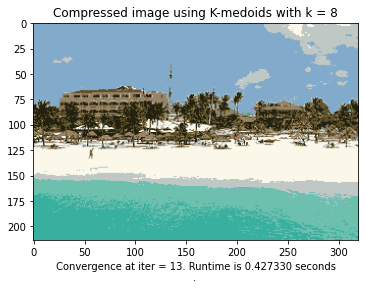

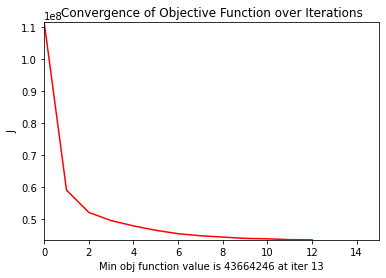

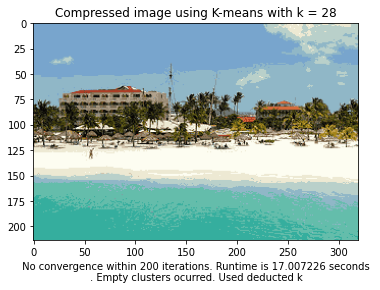

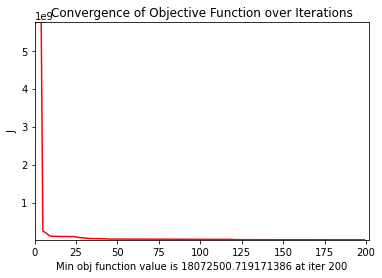

Distribution of cluster assignments:
 [[    1   909]
 [    2  7280]
 [    3   589]
 [    4  4006]
 [    5   371]
 [    6   960]
 [    7   738]
 [    8   286]
 [    9   808]
 [   10  3746]
 [   11  7858]
 [   12   829]
 [   13   204]
 [   14   201]
 [   15   473]
 [   16 10804]
 [   17   973]
 [   18  1017]
 [   19   148]
 [   20   846]
 [   21 12506]
 [   22   683]
 [   23  7983]
 [   24  1236]
 [   25   970]
 [   26   929]
 [   27   758]
 [   28   369]]


In [10]:
### test case

# Load image
image = imageio.imread('data/beach.bmp')         # 214x320x3
#image2 = imageio.imread('data/football.bmp')      # 412x620x3
#image3 = imageio.imread('data/rainbow.bmp')      # 500x331x3

# each image as height x width pixels, each pixel is one data point.
# each data point has 3 columns which indicate the RGB color 
height = image.shape[0]
width = image.shape[1]
colors = image.shape[2]

# reshape image into 1D vector 
pixels = np.reshape(image, (height * width, colors)).T             

# compress image using K medoids
assignments, centroids = compressKmedoids(pixels, 8)

# compress image using K means
assignments, centroids = compressKmeans(pixels, 32)

# print distribution of cluster assignments (optional)
unique, counts = np.unique(assignments, return_counts=True)
print("Distribution of cluster assignments:\n", np.asarray((unique, counts)).T)


## Experimentation and Test Sets

Three images were used to test the K-medoid and K-means implementation:
* Test case 1: footbal.bmp (412x620) (left)
* Test case 2: beach.bmp (214x320) (middle)
* Test case 3: rainbow.bmp (500x331) (right)

<table><tr>
<td> <img src="data/football.bmp" style="width: 280px;"/> </td>
<td> <img src="data/beach.bmp" style="width: 280px;"/> </td>
<td> <img src="data/rainbow.bmp" style="width: 280px;"/> </td>
</tr></table>
    
Four different values of k (2, 8, 16, 32) were tested to compare the performance at small and big numbers of clusters. For each test case, the number of clusters, number of iterations, minimum objective function value, cluster assignment distribution, and system runtime were recorded. 

To compare the performance and robustness of the algorithms, image compression was run on four sets of settings:

* Set A: k-medoids with squared Euclidean distance and random initialization
* Set B: k-medoids with Manhattan distance with random initialization
* Set C: k-means with squared Euclidean distance and random initialization
* Set D: k-medoids with squared Euclidean distance and bad initialization
* Set E: k-means with squared Euclidean distance and bad initialization

## Results and Discussion

**Set-A Results**

The results of image compression using k-medoids with squared Euclidean distance and random initialization are shown below:
* k: user defined number of clusters
* reduced k: if clusters with empty assignments occured, the program will rerun with a reduced k
* convergence: whether the algorithm converged before the maximum number of iterations (200)
* obj function: min value of the distorsion function reached
* run time: computer run time in seconds
* stdev: standard deviation of the cluster assignment distribution as a measure of variability of number of data points assigned to each cluster
        
We can observe that, as the number of cluster increases. the run time increases and the obj function and the stdev decreases. The convergence was reached within 200 iterations for all 16 runs.


<td> <img src="results/A_summary.png" style="width: 600px;"/> </td>

<table><tr>
<td> <img src="results/A_football_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/A_football_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/A_football_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/A_football_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/A_football_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/A_football_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/A_football_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/A_football_k32_2.png" style="width: 200px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="results/A_beach_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/A_beach_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/A_beach_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/A_beach_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/A_beach_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/A_beach_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/A_beach_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/A_beach_k32_2.png" style="width: 200px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="results/A_rainbow_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/A_rainbow_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/A_rainbow_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/A_rainbow_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/A_rainbow_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/A_rainbow_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/A_rainbow_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/A_rainbow_k32_2.png" style="width: 200px;"/> </td>
</tr></table>



**Set-B Results**

The results of image compression using k-medoids with Manhattan distance, random initialization, and 10% downsampling are shown below.

It was obvious to notice that the run time is much longer than set A despite the downsampling, from dozens of seconds to minutes, and run for more iterations. The convergence was not reached within 200 iterations for medium and bigger values of k due to computation complexity. Interestingly, the run time is not necessarily increasing with increased values of k, this mean be due to other tasks running on the computer or how the system distributes its work loads, which we will not investigate in this report.

Note that the graph of objective function over iteration is not stricly decreasing but with small increase/decreases with an overall decreasing trend. This is because 10% downsampling was applied.

Visually looking at the outputs, it is hard to conclude whether set B is better than set A. We cannot directly compare their objective function values either because they used different distance functions.

We will focus our discussion on medoid using squared Euclidean distance since it requires less time complexity to run.


<td> <img src="results/B_summary.png" style="width: 600px;"/> </td>

<table><tr>
<td> <img src="results/B_football_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/B_football_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/B_football_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/B_football_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/B_football_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/B_football_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/B_football_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/B_football_k32_2.png" style="width: 200px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="results/B_beach_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/B_beach_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/B_beach_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/B_beach_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/B_beach_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/B_beach_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/B_beach_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/B_beach_k32_2.png" style="width: 200px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="results/B_rainbow_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/B_rainbow_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/B_rainbow_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/B_rainbow_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/B_rainbow_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/B_rainbow_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/B_rainbow_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/B_rainbow_k32_2.png" style="width: 200px;"/> </td>
</tr></table>


**Set-C Results**

The results of image compression using k-means with squared Euclidean distance and random initialization are shown below.

K-means converges slower than K-medoids for all 16 cases. For larger values of $k$ it was not able to converge within 200 iterations. K-means' run time also increases faster than K-medoids and k increases. 

Most of the times, the objective function values of set A and set C are similar, with K-means performing slightly better for "football.bmp" (a lot of colors) and K-medoids better for "beach.bmp" (quite homogeneous colos).

Looking at the stdev, K-medoids seem to achieve a lower variation of number of pixels assigned to each cluster for larger values of k. However, this observation is not clear and we will not analyze this metric for other test sets.

<td> <img src="results/C_summary.png" style="width: 600px;"/> </td>

<table><tr>
<td> <img src="results/C_football_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/C_football_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/C_football_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/C_football_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/C_football_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/C_football_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/C_football_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/C_football_k32_2.png" style="width: 200px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="results/C_beach_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/C_beach_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/C_beach_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/C_beach_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/C_beach_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/C_beach_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/C_beach_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/C_beach_k32_2.png" style="width: 200px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="results/C_rainbow_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/C_rainbow_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/C_rainbow_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/C_rainbow_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/C_rainbow_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/C_rainbow_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/C_rainbow_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/C_rainbow_k32_2.png" style="width: 200px;"/> </td>
</tr></table>


**Set-D Results**

The results of image compression using k-medoids with squared Euclidean distance and manual bad initialization are shown below.

We can observe that the centroid initialization significantly affects the k-medoids performance. The number of iterations and run time increased by factors of 3-7, and the optimal objective function value is also not as good as in set A.  

<td> <img src="results/D_summary.png" style="width: 600px;"/> </td>

<table><tr>
<td> <img src="results/D_football_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/D_football_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/D_football_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/D_football_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/D_football_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/D_football_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/D_football_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/D_football_k32_2.png" style="width: 200px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="results/D_beach_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/D_beach_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/D_beach_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/D_beach_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/D_beach_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/D_beach_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/D_beach_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/D_beach_k32_2.png" style="width: 200px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="results/D_rainbow_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/D_rainbow_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/D_rainbow_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/D_rainbow_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/D_rainbow_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/D_rainbow_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/D_rainbow_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/D_rainbow_k32_2.png" style="width: 200px;"/> </td>
</tr></table>


**Set-E Results**

The results of image compression using k-means with squared Euclidean distance and manual bad initialization are shown below.

We can observe that the k-means performance has not worsened with a bad initialization. The algorithm reaches similar objective function values, requiring a few more iterations.

<td> <img src="results/E_summary.png" style="width: 600px;"/> </td>

<table><tr>
<td> <img src="results/E_football_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/E_football_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/E_football_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/E_football_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/E_football_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/E_football_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/E_football_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/E_football_k32_2.png" style="width: 200px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="results/E_beach_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/E_beach_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/E_beach_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/E_beach_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/E_beach_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/E_beach_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/E_beach_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/E_beach_k32_2.png" style="width: 200px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="results/E_rainbow_k2_1.png" style="width: 200px;"/> </td>
<td> <img src="results/E_rainbow_k8_1.png" style="width: 200px;"/> </td>
<td> <img src="results/E_rainbow_k16_1.png" style="width: 200px;"/> </td>
<td> <img src="results/E_rainbow_k32_1.png" style="width: 200px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="results/E_rainbow_k2_2.png" style="width: 200px;"/> </td>
<td> <img src="results/E_rainbow_k8_2.png" style="width: 200px;"/> </td>
<td> <img src="results/E_rainbow_k16_2.png" style="width: 200px;"/> </td>
<td> <img src="results/E_rainbow_k32_2.png" style="width: 200px;"/> </td>
</tr></table>

## Conclusions

From the above results, we conclude that under squared-l2 distance:
* k-medoids converges faster than k-means
* k-medoid can achieve similar output qualities as k-means using less number of iterations under random initialization. It is likely that k-means performing slightly better when data points are more heterogeneous; whereas K-medoids can achieve great results when data points are more homogeneous
* k-means is more robust; whereas k-medoids' performance can be significantly affected by  poor initializations

The implementation of k-medoids using distance measures other than squared Euclidean requires long run times. It was hard to tell which had better performance.

